In [12]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.3/917.3 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.6/354.6 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.5/280.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf
from darts.models import ARIMA
import matplotlib.pyplot as plt

In [2]:
tesla_data = yf.download('TSLA', start='2014-01-01', end='2023-11-01', interval = '1mo', progress=False)
tesla_data = tesla_data['Close']  # Nos enfocamos en los precios de cierre


/tmp/ipython-input-2300521338.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tesla_data = yf.download('TSLA', start='2014-01-01', end='2023-11-01', interval = '1mo', progress=False)


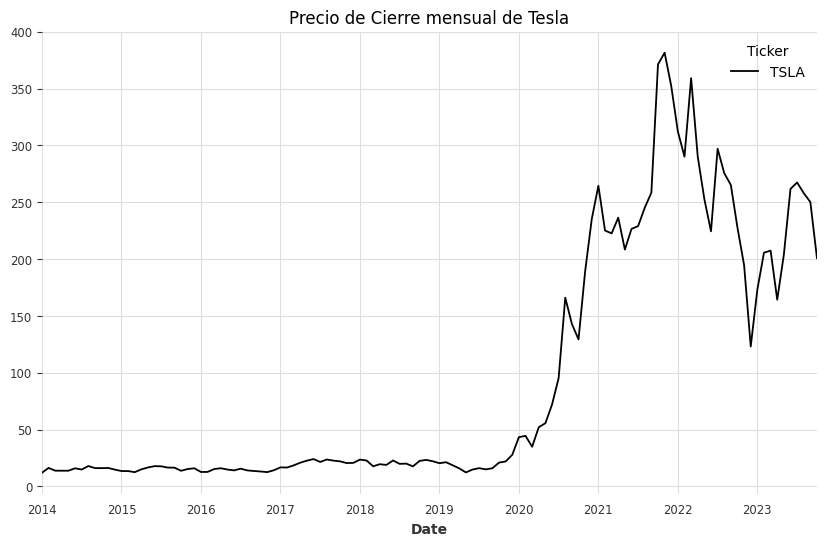

In [3]:
tesla_data.plot(figsize=(10, 6))
plt.title('Precio de Cierre mensual de Tesla')
plt.show()

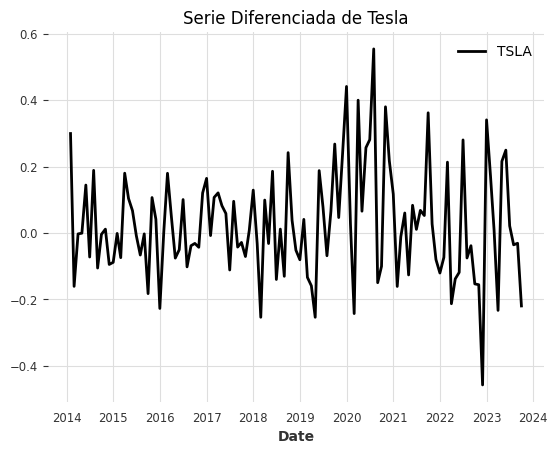

In [4]:
# Aplicando el logaritmo usando NumPy
tesla_log_data = np.log(tesla_data)

# Convertimos al formato
value_col = tesla_log_data.columns[0]

tesla_log_ts = TimeSeries.from_dataframe(
    df=tesla_log_data,
    time_col=None,
    value_cols=value_col,
    fill_missing_dates=True
)

# Diferenciando la serie logarítmica
tesla_diff = tesla_log_ts.diff()


tesla_diff.plot()
plt.title('Serie Diferenciada de Tesla')
plt.show()

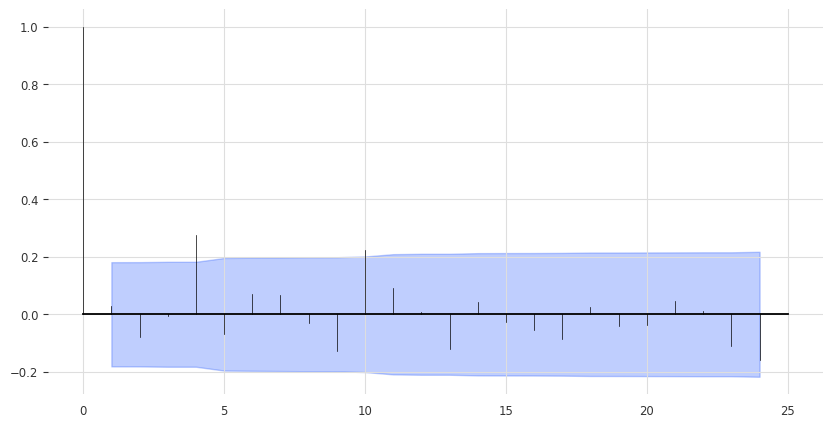

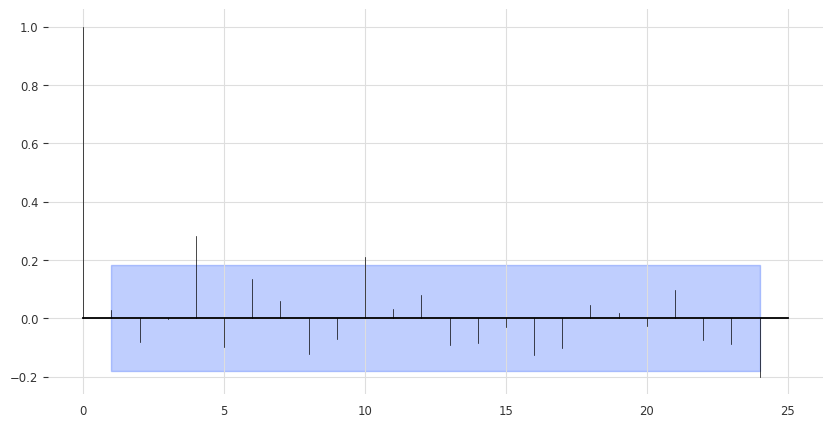

In [5]:
# Graficar ACF
plot_acf(tesla_diff)

# Graficar PACF
plot_pacf(tesla_diff)

In [22]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA as statsmodels_ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Convierte la serie temporal de Darts a una serie de pandas
## Convertimos la serie de tiempo en una serie de pandas
tesla_diff_pd = tesla_diff.pd_series()

## Omitimos las warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

## Definimos el rango de parámetros
p_range = range(0, 5)
q_range = range(0, 5)
d_range = [0]

## Generamos las combinaciones de parámetros
param_combinations = list(itertools.product(p_range, d_range, q_range))

best_aic = np.inf
best_params = None
best_model = None

print("Buscando los mejores parámetros ARIMA...")
print("-" * 60)

## Probamos cada combinación
for params in param_combinations:
    try:
        ## Ajustamos el modelo ARIMA
        model = statsmodels_ARIMA(tesla_diff_pd, order=params)
        fitted_model = model.fit()

        ## Obtenemos el AIC
        aic = fitted_model.aic

        ## Imprimimos el progreso
        print(f"ARIMA{params} - AIC: {aic:.4f}")

        ## Actualizamos el mejor modelo en caso de ser necesario
        if aic < best_aic:
            best_aic = aic
            best_params = params
            best_model = fitted_model

    except Exception as e:
        ## Ignoramos modelos que no convergen
        print(f"ARIMA{params} - Error: {str(e)[:50]}")
        continue

print("-" * 60)
print(f"\nMejor modelo: ARIMA{best_params}")
print(f'AIC auto modelo: {best_aic}')

auto_model = best_model
aic_value_auto = best_aic

Buscando los mejores parámetros ARIMA...
------------------------------------------------------------
ARIMA(0, 0, 0) - AIC: -86.9136
ARIMA(0, 0, 1) - AIC: -85.0218
ARIMA(0, 0, 2) - AIC: -83.5103
ARIMA(0, 0, 3) - AIC: -81.6597
ARIMA(0, 0, 4) - AIC: -91.8217
ARIMA(1, 0, 0) - AIC: -85.0037
ARIMA(1, 0, 1) - AIC: -83.1246
ARIMA(1, 0, 2) - AIC: -81.5192
ARIMA(1, 0, 3) - AIC: -85.5506
ARIMA(1, 0, 4) - AIC: -89.8260
ARIMA(2, 0, 0) - AIC: -83.8211
ARIMA(2, 0, 1) - AIC: -81.8211
ARIMA(2, 0, 2) - AIC: -90.3617
ARIMA(2, 0, 3) - AIC: -91.4350
ARIMA(2, 0, 4) - AIC: -90.7835
ARIMA(3, 0, 0) - AIC: -81.8212
ARIMA(3, 0, 1) - AIC: -85.4595
ARIMA(3, 0, 2) - AIC: -91.9152
ARIMA(3, 0, 3) - AIC: -90.0224
ARIMA(3, 0, 4) - AIC: -90.5564
ARIMA(4, 0, 0) - AIC: -89.0412
ARIMA(4, 0, 1) - AIC: -89.0352


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(4, 0, 2) - AIC: -87.1815
ARIMA(4, 0, 3) - AIC: -89.9219
ARIMA(4, 0, 4) - AIC: -88.5341
------------------------------------------------------------

Mejor modelo: ARIMA(3, 0, 2)
AIC auto modelo: -91.91519022369866


In [23]:
## Obtenemos los parámetros estimados del modelo seleccionado
estimated_params = auto_model.params
print(f'Parámetros estimados: {estimated_params}')

Parámetros estimados: const     0.023094
ar.L1    -1.053393
ar.L2    -0.863945
ar.L3    -0.181386
ma.L1     1.166642
ma.L2     0.893436
sigma2    0.023256
dtype: float64


In [24]:
tesla_data.tail()

Ticker,TSLA
Date,
2023-06-01,261.769989
2023-07-01,267.429993
2023-08-01,258.079987
2023-09-01,250.220001
2023-10-01,200.839996


In [25]:
import numpy as np

## Predecimos la serie diferenciada X_t para los próximos n periodos
future_diff_preds = auto_model.forecast(steps=10)

## Obtenemos el último valor del logaritmo de Y_t
log_Y_last = tesla_log_ts.pd_series().iloc[-1]

## Integramos las predicciones diferenciadas para obtener las predicciones
## del logaritmo de Y_t
log_Y_preds = log_Y_last + np.cumsum(future_diff_preds)

## Exponenciamos las predicciones del logaritmo de Y_t para obtener
## las predicciones de Y_t
Y_preds = np.exp(log_Y_preds)

## Creamos un dataframe con fechas (esto es simplemente para tener una mejor visualización)
forecast_dates = pd.date_range(start=tesla_data.index[-1] + pd.DateOffset(months=1),
                                periods=10,
                                freq='MS')
Y_preds = pd.DataFrame({'predicted_mean': Y_preds}, index=forecast_dates)

In [26]:
Y_preds

,predicted_mean
2023-11-01,198.525365
2023-12-01,210.163521
2024-01-01,223.480791
2024-02-01,214.659115
2024-03-01,225.794077
2024-04-01,235.465141
2024-05-01,233.354579
2024-06-01,241.821181
2024-07-01,250.232161
2024-08-01,251.835727
